# Assignment 2 - Gesture Recognition

## Imports

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import callbacks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import time
import os

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Random Seed
Random seed based on my college number (G00385433)

In [2]:
seed = 385433

In [3]:
# Print TensorFlow version and check for GPU
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.19.0
[]


## Loading and Preparing the Dataset

The following steps outline the process of loading image data from a directory, flattening the images into a feature array, encoding labels, and normalizing pixel values.

### Steps:
1. **Define the dataset path**: Set the path to the folder containing images which are organized in category subfolders.
2. **Retrieve image paths**: Use `glob` to collect all `.png` image file paths.
3. **Load and preprocess images**: Read images and flatten them into a feature array (`X`).
4. **Extract and encode labels**: Get category names (folder names) and encode them numerically. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
5. **Normalize pixel values**: Scale pixel values to the range `[0,1]`.

In [4]:
# dataset path
# data_dir = ''


# ## Setting Up the Dataset
# 
# Starting with a smaller image size (128x128) for faster training

# In[ ]:

IMG_SIZE = (128, 128)
batch_size = 32

# Change this to your dataset path
# For HAGRID dataset:
train_dir = "dataset/hagridset"
# For Rock Paper Scissors dataset:
# train_dir = "rps_dataset" 

In [5]:
# Training dataset (70%)
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=IMG_SIZE, 
    validation_split=0.3,  # 30% will be split between validation and test
    subset='training', 
    label_mode='categorical',
    seed=seed, 
    batch_size=batch_size
)

Found 125912 files belonging to 18 classes.
Using 88139 files for training.


In [6]:
# Temporary validation dataset (30% of total)
temp_val_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=IMG_SIZE, 
    validation_split=0.3,
    subset='validation',
    label_mode='categorical',
    seed=seed, 
    batch_size=batch_size
)

Found 125912 files belonging to 18 classes.
Using 37773 files for validation.


In [7]:
num_classes = len(train_dataset.class_names)

class_names = train_dataset.class_names
class_names

['call',
 'dislike',
 'fist',
 'four',
 'like',
 'mute',
 'ok',
 'one',
 'palm',
 'peace',
 'peace_inverted',
 'rock',
 'stop',
 'stop_inverted',
 'three',
 'three2',
 'two_up',
 'two_up_inverted']

In [8]:
# Split the temp_val_dataset into validation (10% of total) and test (20% of total)
val_batches = tf.data.experimental.cardinality(temp_val_dataset) // 3
test_batches = tf.data.experimental.cardinality(temp_val_dataset) - val_batches

validation_dataset = temp_val_dataset.take(val_batches)
test_dataset = temp_val_dataset.skip(val_batches)

print(f"Number of training batches: {tf.data.experimental.cardinality(train_dataset)}")
print(f"Number of validation batches: {tf.data.experimental.cardinality(validation_dataset)}")
print(f"Number of test batches: {tf.data.experimental.cardinality(test_dataset)}")

Number of training batches: 2755
Number of validation batches: 393
Number of test batches: 788


In [9]:
# # Get class names and number of classes
# num_classes = len(train_dataset.class_names)
# class_names = train_dataset.class_names
# print(f"Found {num_classes} classes: {class_names}")

# Optimize dataset loading performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

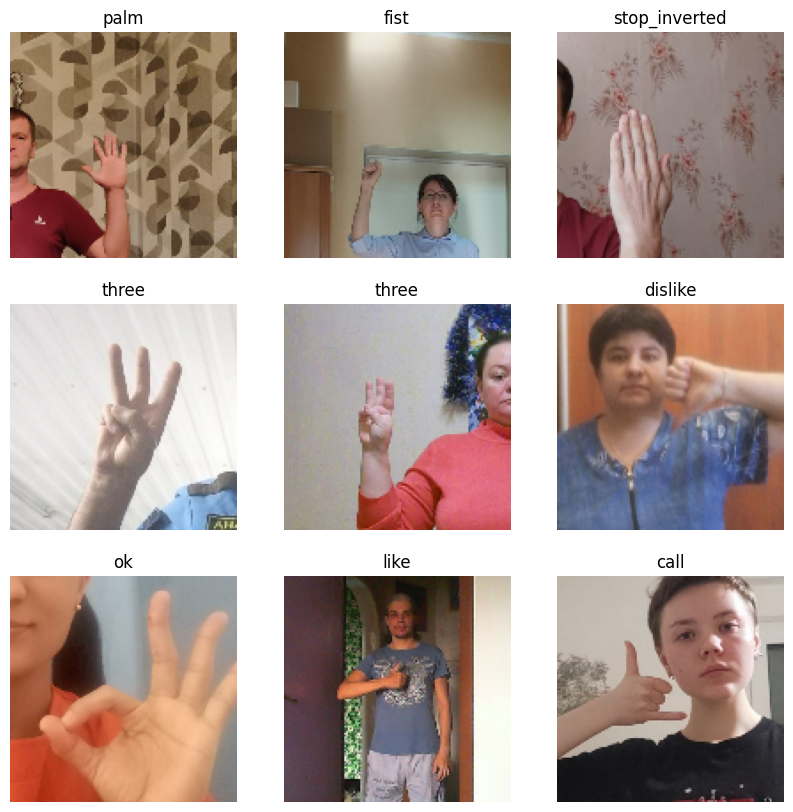

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = np.argmax(labels[i])
        plt.title(class_names[label_index])
        plt.axis("off")
plt.show()

In [ ]:
# Apply limit to dataset size for faster training
LIMIT_BATCHES = 500  # adjust this depending on your GPU/CPU speed

# Reduce size of train and validation sets
train_dataset_small = train_dataset.take(LIMIT_BATCHES)
validation_dataset_small = validation_dataset.take(LIMIT_BATCHES // 3)

# Define model with augmentation, dropout, and L2 regularization
data_augmentation_layers = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
])

weight_decay = 1e-4  # L2 regularization strength

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    data_augmentation_layers,
    layers.Rescaling(1./255),

    layers.Conv2D(16, 3, padding='same', activation='relu',
                  kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),  # dropout after first block

    layers.Conv2D(32, 3, padding='same', activation='relu',
                  kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Conv2D(64, 3, padding='same', activation='relu',
                  kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(128, activation='relu',
                 kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()

# Early stopping callback
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Track training time
start_time = time.time()

# Train the model on reduced dataset
history = model.fit(
    train_dataset_small,
    validation_data=validation_dataset_small,
    epochs=100,
    callbacks=[callback]
)

training_time = time.time() - start_time
print(f"Training time: {training_time:.2f} seconds")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Layer (type)             ┃ Output Shape      ┃   Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ sequential (Sequential)  │ (None, 128, 128,  │         0 │
│                          │ 3)                │           │
├──────────────────────────┼───────────────────┼───────────┤
│ rescaling (Rescaling)    │ (None, 128, 128,  │         0 │
│                          │ 3)                │           │
├──────────────────────────┼───────────────────┼───────────┤
│ conv2d (Conv2D)          │ (None, 128, 128,  │       448 │
│                          │ 16)               │           │
├──────────────────────────┼───────────────────┼───────────┤
│ max_pooling2d            │ (None, 64, 64,    │         0 │
│ (MaxPooling2D)           │ 16)               │           │
├──────────────────────────┼───────────────────┼───────────┤
│ dropout (Dropout)        │ (None, 64, 64,    │         0 │
│                          │ 16)               │           │
├──────────────────────────┼───────────────────┼───────────┤
│ conv2d_1 (Conv2D)        │ (None, 64, 64,    │     4,640 │
│                          │ 32)               │           │
├──────────────────────────┼───────────────────┼───────────┤
│ max_pooling2d_1          │ (None, 32, 32,    │         0 │
│ (MaxPooling2D)           │ 32)               │           │
├──────────────────────────┼───────────────────┼───────────┤
│ dropout_1 (Dropout)      │ (None, 32, 32,    │         0 │
│                          │ 32)               │           │
├──────────────────────────┼───────────────────┼───────────┤
│ conv2d_2 (Conv2D)        │ (None, 32, 32,    │    18,496 │
│                          │ 64)               │           │
├──────────────────────────┼───────────────────┼───────────┤
│ max_pooling2d_2          │ (None, 16, 16,    │         0 │
│ (MaxPooling2D)           │ 64)               │           │
├──────────────────────────┼───────────────────┼───────────┤
│ dropout_2 (Dropout)      │ (None, 16, 16,    │         0 │
│                          │ 64)               │           │
├──────────────────────────┼───────────────────┼───────────┤
│ flatten (Flatten)        │ (None, 16384)     │         0 │
├──────────────────────────┼───────────────────┼───────────┤
│ dense (Dense)            │ (None, 128)       │ 2,097,280 │
├──────────────────────────┼───────────────────┼───────────┤
│ dropout_3 (Dropout)      │ (None, 128)       │         0 │
├──────────────────────────┼───────────────────┼───────────┤
│ dense_1 (Dense)          │ (None, 18)        │     2,322 │
└──────────────────────────┴───────────────────┴───────────┘

 Total params: 2,123,186 (8.10 MB)

 Trainable params: 2,123,186 (8.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 187s 346ms/step - accuracy: 0.0548 - loss: 2.9331 - val_accuracy: 0.0589 - val_loss: 2.9014
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 160s 319ms/step - accuracy: 0.0593 - loss: 2.8992 - val_accuracy: 0.0593 - val_loss: 2.8950
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 187s 373ms/step - accuracy: 0.0624 - loss: 2.8939 - val_accuracy: 0.0589 - val_loss: 2.8927
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 173s 344ms/step - accuracy: 0.0598 - loss: 2.8921 - val_accuracy: 0.0529 - val_loss: 2.8918
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 174s 347ms/step - accuracy: 0.0599 - loss: 2.8912 - val_accuracy: 0.0589 - val_loss: 2.8912
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 176s 351ms/step - accuracy: 0.0578 - loss: 2.8907 - val_accuracy: 0.0595 - val_loss: 2.8909
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 168s 335ms/step - accuracy: 0.0588 - loss: 2.8904 - val_accuracy: 0.0597 - val_loss: 2.8906
Epoch 8/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 169s 337ms/step - accuracy: 

In [ ]:
# Visualize training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Early stopping callback to prevent overfitting
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

# In[ ]:

# Track training time
start_time = time.time()

# Train the model
history = model.fit(
    train_dataset, 
    validation_data=validation_dataset, 
    epochs=100, 
    callbacks=[callback]
)

# Calculate training time
training_time = time.time() - start_time
print(f"Training time: {training_time:.2f} seconds")

# In[ ]:

# Visualize training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### END